# Complete Exploratory Data Analysis

## Georgia Tech MSA Spring 2026 Practicum

This is where your full EDA goes. We look forward to digging deeper into your analysis here.

Read the [eda_outline.md](eda_outline.md) for more details.

In [183]:
# Setup
# %pip install itables
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display
from itables import init_notebook_mode

import sys
import importlib
# Add analysis folder to Python path
project_root = Path.cwd().parent  # Go from eda/ to project root
sys.path.append(str(project_root / 'analysis'))

import wc_prediction
importlib.reload(wc_prediction)

DATA_DIR = Path("..") / "data" / "Statsbomb"

# Import custom modules 
from data_loader import TacticalDataLoader
from profile_builder import build_team_profile
from clustering_analysis import TacticalClustering
from visualization import (
    plot_eda_compact, 
    plot_clustering_validation_compact,
    plot_archetype_summary,
    save_figure,
    plot_tactical_pca,
    plot_archetype_radars,
    plot_compression_overlay,
    print_cmi_table,
    plot_side_by_side
)
from tournament_compression import (
    assign_to_archetypes,
    calculate_cmi,
    analyze_archetype_distribution_shift,
    analyze_archetype_shift,
    plot_archetype_shift,
    print_archetype_shift_table,
    calculate_archetype_success,
)
from rosters_2026 import rosters_2026
from tournament_progression import merge_progression, print_progression_summary, plot_paradox_scatter, plot_success_by_archetype, plot_progression_by_round, print_matchup_matrix, print_matchup_matrix, build_match_results, archetype_vs_archetype
from wc_prediction import predict_team_archetypes, print_prediction_table, print_team_detail, calculate_tri, print_tri_table, analyze_matchup, print_tri_table

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

# Create output directories (relative to notebook location)
Path('../processed').mkdir(parents=True, exist_ok=True)
Path('../figures').mkdir(parents=True, exist_ok=True)

print("Setup complete")

Setup complete


# Phase 1: The Tactical Atlas

## Mapping the Full Spectrum of Club Tactical Identity

A fingerprint means nothing in isolation. Its value comes from comparison: from placing it against a database of known prints and asking: *who does this belong to?*

We now have 1,823 fingerprints, one for every match in the 2015/16 Big 5 leagues. Each is a 12-dimensional vector encoding how a team attacked, defended, and occupied space in that specific 90 minutes. The question is whether this apparent chaos contains structure. Do the 1,823 fingerprints cluster into a manageable number of recognizable tactical families - and if so, what do those families look like?

The answer will become our tactical atlas: a map of everything elite club football can be.

In [2]:
loader = TacticalDataLoader()
metrics_baseline = loader.load_scope('men_club_2015', verbose=False)
# Build profiles
men_club_profiles = build_team_profile(metrics_baseline, verbose=False)
# Convert to pandas for analysis
men_club_pd = men_club_profiles.to_pandas()
# Save
men_club_profiles.write_csv('../processed/men_club_profiles_2015_16.csv')
display(men_club_pd.head())

,team,possession_dominance,territorial_control,possession_efficiency,progression_intensity,progression_method,buildup_complexity,offensive_threat,tempo,press_intensity,defensive_line_height,press_effectiveness,counter_speed
0,Nantes,48.753947,24.457895,0.011258,85.894737,0.433763,0.087026,0.936836,4.074474,0.136259,1.452947,0.456328,3.511316
1,Borussia Dortmund,63.649706,24.292647,0.026974,116.764706,0.415971,0.173147,2.268885,6.240000,0.140880,1.579676,0.458128,3.491765
2,Athletic Club,49.590263,24.368684,0.019426,82.921053,0.428895,0.105158,1.322900,3.979737,0.142659,1.517737,0.471008,3.731053
3,Inter Milan,54.733947,25.702368,0.018585,85.473684,0.466316,0.104789,1.351698,4.783421,0.111183,1.456974,0.442080,3.775526
4,West Ham United,48.381316,26.070263,0.023366,73.447368,0.500105,0.098711,1.434909,3.935789,0.114901,1.389158,0.463416,3.751053


## Finding Structure in 12 Dimensions

Twelve dimensions are too many for the human eye to parse. But clustering algorithms thrive in high-dimensional space. We apply k-means clustering to the 1,823 match profiles, but first we must answer the most important methodological question: **how many archetypes exist?**

Rather than imposing a number, we let the data speak. We evaluate cluster 
quality across k=2 through k=8 using three complementary metrics: the 
Silhouette Score (measuring how well-separated clusters are), the 
Calinski-Harabasz Index (ratio of between-cluster to within-cluster 
variance), and the Davies-Bouldin Index (measuring average similarity 
between clusters, where lower is better).

Saved: outputs/figures/men_cluster_optimization.png


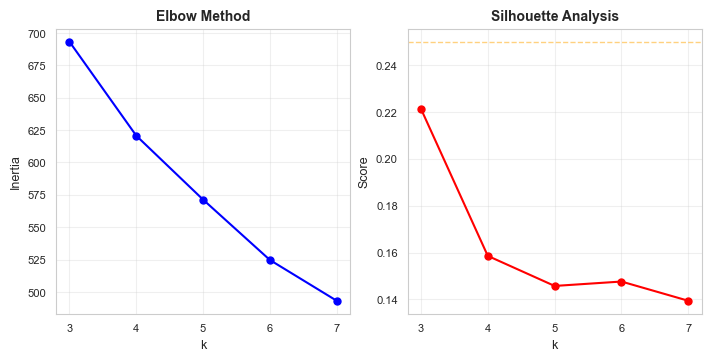

k,Inertia ↓,Silhouette ↑,Calinski-Harabasz ↑,Davies-Bouldin ↓
3,693,0.221 ✓,33.07 ✓,1.499 ✓
4,621,0.159,28.04,1.551
5,571,0.146,24.61,1.668
6,525,0.148,22.84,1.612
7,493,0.139,21.00,1.534



Running K-means (k=3)...


In [98]:
# Initialize clustering
dimensions = [
    'possession_dominance', 'territorial_control', 'possession_efficiency',
    'progression_intensity', 'progression_method', 'buildup_complexity',
    'offensive_threat', 'tempo', 'press_intensity',
    'defensive_line_height', 'press_effectiveness', 'counter_speed'
]
clusterer = TacticalClustering(dimensions)
scaled_data = clusterer.prepare_data(men_club_pd)

# Optimize k 
optimization_results = clusterer.optimize_k(k_range=range(3, 8))
fig, axes = plot_clustering_validation_compact(optimization_results)
save_figure(fig, 'men_cluster_optimization.png')
plt.show()

# Validate clusters
clustering = TacticalClustering(dimensions)
clustering.prepare_data(men_club_pd)
k_results = clustering.print_k_comparison(k_range=range(3, 8))

# Run k-means with k=3
print("\nRunning K-means (k=3)...")
clustering_results = clusterer.run_kmeans(k=3, random_state=42)

# Add labels to dataframe
men_club_pd['cluster'] = clustering_results['labels']
cluster_centers = clustering_results['centers']

# Add cluster sizes
cluster_centers['size'] = men_club_pd['cluster'].value_counts().sort_index().values

## Interpreting the Structure

The silhouette score of 0.219 warrants honest discussion. This is not a dataset 
with dramatic, well-separated clusters - and we should not pretend otherwise. 
Football tactics exist on a continuum, not in discrete categories. No team is 
*purely* a possession side or *purely* a counter-attacking side; every tactical 
identity is a blend.

What the clustering *does* find is meaningful gravitational structure within that 
continuum. Three pieces of evidence support k=3 as a useful taxonomy:

- First, **algorithmic agreement**. K-means and Gaussian Mixture Models — two 
fundamentally different approaches to clustering — agree on 78.4% of assignments 
(ARI = 0.784). When different methods converge on the same groupings, the 
structure is unlikely to be an artifact.

- Second, **variance compression**. Three archetypes explain 41% of the tactical 
variance across 1,823 matches. Reducing twelve dimensions to three categories 
and retaining nearly half the information is a meaningful simplification.

- Third, **uneven cluster cohesion**. The per-cluster silhouette scores (0.267, 
0.201, 0.157) reveal that some tactical philosophies are more tightly defined 
than others. This asymmetry is itself informative — we will see that the most 
cohesive archetype corresponds to possession-based systems, suggesting these 
teams converge on a narrower set of principles than their counterparts.

These archetypes are best understood not as rigid categories but as the three 
strongest attractors in tactical space — the styles that teams gravitate toward, 
even as individual implementations vary.

↑,Press Intensity,+0.72 std
↑,Press Effectiveness,+0.72 std
↑,Defensive Line Height,+0.60 std
↓,Progression Method,-0.13 std
↑,Progression Method,+0.30 std
↑,Counter Speed,+0.07 std
↑,Territorial Control,-0.33 std
↓,Defensive Line Height,-0.65 std
↓,Press Effectiveness,-0.60 std
↓,Offensive Threat,-0.59 std
↑,Offensive Threat,+2.37 std


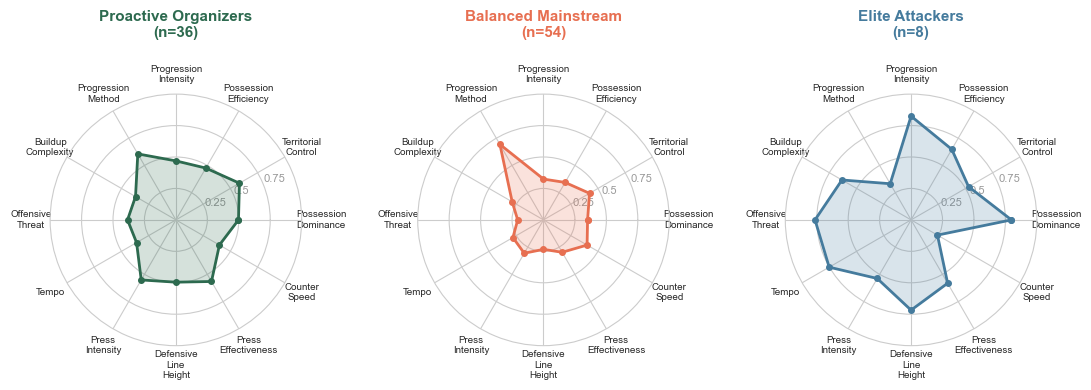

In [109]:
# Characterize
characterization = clusterer.characterize_archetypes(
    men_club_pd, 
    cluster_centers, 
    clustering_results['labels'],
    archetype_names
)
clustering.print_archetype_summary(characterization)
fig_radars = plot_archetype_radars(cluster_centers, dimensions, archetype_names, men_club_pd)

## The Three Archetypes

The data suggests three fundamental approaches to the game at the elite level. 
Every match in the Big 5 — from Guardiola's meticulous positional play to 
Simeone's defensive discipline — is a variation on one of three tactical 
philosophies.

### Proactive Organizers (n=36, 36.7%)

The hunters. These teams define themselves through defensive *aggression* rather 
than defensive *depth*. They press higher (+0.72 std above average), press more 
effectively (+0.72 std), and push their defensive line forward (+0.60 std). 
The trade-off is subtle — they don't sacrifice much, which is why this 
archetype contains recognizable names from across Europe's top leagues. These 
are well-coached teams that impose structure on both phases of play.

**Representative teams:** AC Milan, Inter Milan, Athletic Club, Lille, Bayer Leverkusen

### Balanced Mainstream (n=54, 55.1%)

The majority. Over half of elite European teams play a moderate, non-extreme 
style — slightly more direct in progression (+0.30 std), but otherwise defined 
more by what they *don't* do than what they do. They press less, sit deeper, 
and create fewer high-quality chances than either of the other archetypes. This 
is the gravitational center of elite football: pragmatic, adaptable, and 
unremarkable in any single dimension.

**Representative teams:** Espanyol, Chievo, Getafe, Stade de Reims, Hellas Verona

### Elite Attackers (n=8, 8.2%)

The outliers. Just eight teams occupy this space, and the numbers explain why: 
offensive threat +2.37 std above average, tempo +2.32 std, progression 
intensity +2.31 std. These teams don't just attack — they attack at a pace 
and quality that is statistically *rare*. The cost is visible in their 
trade-offs: they abandon direct progression methods (-1.48 std) in favor of 
intricate, patient buildup, and they sacrifice counter-attacking speed (-0.75 
std) because they rarely need to counter — they already have the ball.

That only 8.2% of elite teams can sustain this style hints at its fragility. 
It requires extraordinary technical quality across the squad. This will become 
critical when we examine whether this style survives the transition to 
international football.

**Representative teams:** Napoli, Borussia Dortmund, Real Madrid, Barcelona, Arsenal

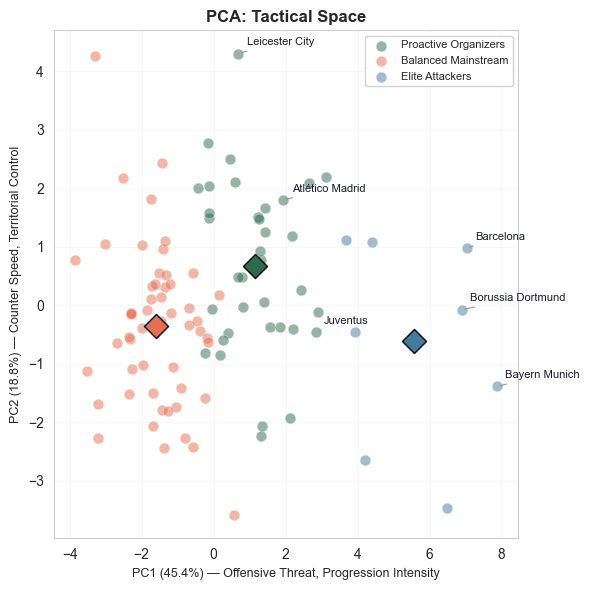

In [112]:
# Define archetype names
archetype_names = {
    0: "Proactive Organizers",
    1: "Balanced Mainstream",
    2: "Elite Attackers"
}

men_club_pd['archetype_name'] = men_club_pd['cluster'].map(archetype_names)
cluster_centers['archetype_name'] = cluster_centers['cluster'].map(archetype_names)

# PCA map with notable teams annotated
fig_pca, pca = plot_tactical_pca(
    men_club_pd, dimensions, men_club_pd['cluster'], archetype_names,
    highlight_teams=['Barcelona', 'Atlético Madrid', 'Leicester City', 
                     'Bayern Munich', 'Juventus', 'Borussia Dortmund']
)

## Reading the Map

The projection reveals the geography of elite club football. Three observations 
stand out.

- First, **the Balanced Mainstream dominates the center**. The 54 teams in this 
archetype cluster tightly around the origin — they are, almost by definition, 
average. The tactical center of gravity in European football is moderate 
pressing, moderate possession, moderate ambition.

- Second, **Elite Attackers are isolated**. The eight teams in orange sit far to 
the right of the map, separated from the rest by a visible gap on PC1. This 
isn't a gradual spectrum — there is a discontinuity between "good attacking 
teams" and the small group that operates at a fundamentally different offensive 
intensity. Barcelona, Dortmund, Napoli, and Real Madrid don't just do more of 
what other teams do. They do something qualitatively different.

- Third, **Proactive Organizers spread vertically**. Their variation is mostly 
along PC2, suggesting that while these teams agree on pressing philosophy, they 
diverge on how they build attacks. AC Milan and Lille share a defensive 
approach but construct their offense differently.

This is the full landscape of tactical possibility when time and preparation are 
abundant. Club managers have preseasons, daily training sessions, mid-season 
adjustments — the luxury of repetition. But international football operates 
under a fundamentally different constraint. A World Cup squad assembles days 
before the tournament begins. The manager inherits talent but not chemistry.

**The question we turn to now: when you compress months of preparation into 
days, what happens to this map?**

# Phase 2: The Compression

## The 10-Day Problem: How Tournaments Shrink the Tactical Map

In June 2022, 32 nations arrived in Qatar with squads assembled from clubs 
spanning dozens of leagues, tactical systems, and footballing cultures. Each 
manager faced the same problem: forge a coherent tactical identity from players 
who, weeks earlier, were executing entirely different systems for their clubs.

Some managers solve this by imposing a complex vision and hoping elite players 
adapt quickly. Most solve it by simplifying.

We now project tournament matches — drawn from the 2022 World Cup, 2024 
European Championship, and 2024 Copa América — onto the tactical atlas we 
built from club football. If tournaments force simplification, we should see 
it: the tournament cloud should occupy less space than the club cloud. The 
extremes should vanish. The map should shrink.

Tournament teams: 52
Same-era club teams: 38

--------------------------------------------------

Tournament archetype distribution:
  Proactive Organizers: 9 (17.3%)
  Balanced Mainstream: 40 (76.9%)
  Elite Attackers: 3 (5.8%)

Same-era clubs archetype distribution:
  Proactive Organizers: 7 (18.4%)
  Balanced Mainstream: 25 (65.8%)
  Elite Attackers: 6 (15.8%)


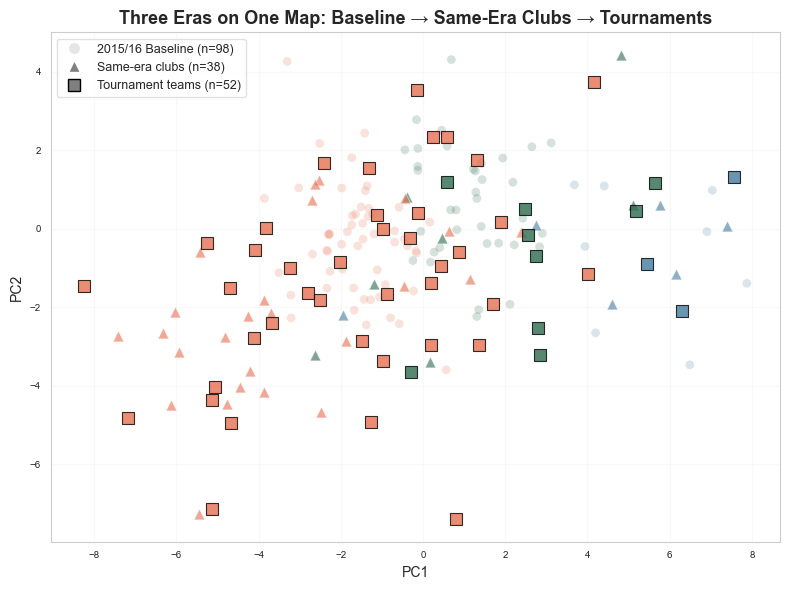

In [111]:
# Step 1: Load tournament data
metrics_tournament = loader.load_scope('men_tournaments_2022_24', verbose=False)
men_tournament_profiles = build_team_profile(metrics_tournament, verbose=False)
men_tournament_pd = men_tournament_profiles.to_pandas()
men_tournament_profiles.write_csv('../processed/men_tournament_profiles_2022_24.csv')

men_tournament_pd = assign_to_archetypes(men_tournament_pd, cluster_centers, dimensions)
men_tournament_pd['archetype_name'] = men_tournament_pd['assigned_archetype'].map(archetype_names)

print(f"Tournament teams: {len(men_tournament_pd)}")

# Step 2: Load same-era club data
metrics_recent = loader.load_scope('recent_club_validation', verbose=False)
recent_club_profiles = build_team_profile(metrics_recent, verbose=False)
recent_club_pd = recent_club_profiles.to_pandas()
recent_club_profiles.write_csv('../processed/recent_club_profiles_2022_23.csv')

recent_club_pd = assign_to_archetypes(recent_club_pd, cluster_centers, dimensions)
recent_club_pd['archetype_name'] = recent_club_pd['assigned_archetype'].map(archetype_names)

print(f"Same-era club teams: {len(recent_club_pd)}")

# Step 3: Project both into baseline PCA space
if clustering.pca is None:
    clustering.run_pca(n_components=2)

for df in [men_tournament_pd, recent_club_pd]:
    scaled = clustering.scaler.transform(df[dimensions])
    pca_coords = clustering.pca.transform(scaled)
    df['PC1'] = pca_coords[:, 0]
    df['PC2'] = pca_coords[:, 1]

# Step 4: Print archetype distributions
print("\n" + "-" * 50)
for label, df in [('Tournament', men_tournament_pd), ('Same-era clubs', recent_club_pd)]:
    print(f"\n{label} archetype distribution:")
    for cid, name in archetype_names.items():
        count = (df['assigned_archetype'] == cid).sum()
        print(f"  {name}: {count} ({count/len(df)*100:.1f}%)")

fig, ax = plot_compression_overlay(men_club_pd, recent_club_pd, men_tournament_pd, archetype_names)
plt.savefig('../figures/compression_three_layer.png', dpi=150, bbox_inches='tight')
plt.show()

## Reading the Compression

The three-layer overlay reveals the tournament effect visually. The faint 
circles map the full 2015/16 baseline — the widest spread of tactical 
possibility. The triangles show same-era clubs occupying a similar range. 
The bold squares show where tournament teams land.

Three patterns emerge.

First, **the center holds**. Tournament teams concentrate in the middle of 
the map. The extreme positions on both ends of PC1 — the most defensive and 
most attacking profiles — are occupied almost exclusively by club teams. 
Tournaments pull teams toward the tactical mean.

Second, **the vertical spread persists**. Tournament teams scatter broadly 
along PC2, suggesting that while offensive intensity compresses (PC1), the 
defensive and pressing dimension (PC2) remains a genuine axis of variation 
in international football. Managers still make distinct choices about how 
to defend, even when attacking complexity narrows.

Third, **the Balanced Mainstream absorbs everything**. The pink squares 
dominate the tournament layer. Teams that might have been Proactive 
Organizers or borderline Elite Attackers at club level drift toward the 
middle archetype when preparation time shrinks. The mainstream gets more 
mainstream.

The visual tells the story, but we need numbers. How much compression are 
we actually seeing — and which dimensions drive it?

In [108]:
cmi_results = calculate_cmi(recent_club_pd, men_tournament_pd, dimensions)
print_cmi_table(cmi_results)


Overall CMI: 0.893
Overall Compression: 10.7%


Dimension,CMI,Compression,,Level
Possession Efficiency,0.525,+47.5%,,HIGH
Buildup Complexity,0.601,+39.9%,,HIGH
Press Effectiveness,0.780,+22.0%,,HIGH
Progression Intensity,0.797,+20.3%,,HIGH
Defensive Line Height,0.827,+17.3%,,HIGH
Progression Method,0.875,+12.5%,,MOD
Offensive Threat,0.893,+10.7%,,MOD
Territorial Control,0.944,+5.6%,,MOD
Possession Dominance,0.949,+5.1%,,MOD
Tempo,1.076,-7.6%,,LOW


## What Compresses — and What Doesn't

The compression is not uniform. This is the central finding of Phase 2, and 
it reveals the mechanism behind tactical simplification in tournaments.

**High compression (the coordination-dependent tactics):**
Possession Efficiency (+47.5%) and Buildup Complexity (+39.9%) compress the 
most. These are the dimensions that require the deepest mutual understanding 
— knowing where teammates will be, anticipating movements, executing 
rehearsed passing patterns under pressure. Press Effectiveness (+22.0%) and 
Progression Intensity (+20.3%) follow closely. All four share a common 
trait: they depend on synchronized collective behavior that takes weeks of 
training to develop.

**Low compression (or rather, expansion):**
Three dimensions actually show *more* variance in tournaments than in clubs. 
Press Intensity (-33.2%), Counter Speed (-11.3%), and Tempo (-7.6%) all 
expand. This is not noise — it's revealing. These dimensions measure 
*choices* rather than *capabilities*. Any team can choose to press high or 
sit deep. Any team can choose to counter quickly or slow the game down. 
These are tactical instructions a manager can give in a team meeting. They 
don't require rehearsal. They require a decision.

**The pattern is clear:** dimensions that measure *how well* teams execute 
complex coordinated behaviors compress in tournaments. Dimensions that 
measure *what teams choose to do* — simple strategic decisions — actually 
diversify, as managers with different philosophies make different bets with 
the limited tools available to them.

This asymmetry is the fingerprint of the 10-day problem. Tournaments don't 
make teams tactically identical. They strip away the rehearsed complexity 
while amplifying the strategic choices that remain.

## The Map Has Shrunk

Tournament football is measurably less diverse than same-era club football. 
Possession Efficiency and Buildup Complexity — the dimensions most dependent 
on coordinated, rehearsed behavior — lose nearly half their variance. 
Meanwhile, strategic choice dimensions like Press Intensity actually 
*expand* in tournaments, as managers diverge on the simple decisions they 
can still control.

The compression is real, selective, and explainable. But a descriptive 
finding only matters if it has consequences. The natural next question: 
**does tactical compression predict tournament success?** Do teams that 
resist simplification outperform — or does pragmatic adaptation win?

# Phase 3: The Translation Problem

## Which Tactics Survive — and Which Win?

Compression is a fact. Tournaments narrow the tactical map, erode coordination-
heavy dimensions, and push three-quarters of teams toward the Balanced 
Mainstream. But description is not insight. The question that matters is 
whether compression *predicts outcomes*.

The rarest archetype in tournaments — Elite Attackers, just 6% of teams — is 
also the most demanding. It requires the kind of collective technical quality 
that most national teams cannot assemble in ten days. But the teams that *can* 
sustain it might hold a decisive advantage precisely because so few opponents 
are prepared to face it.

We now connect tactical identity to tournament results. For every team in our 
dataset, we know two things: how they play (their archetype assignment) and 
how far they go (their tournament progression). The question is simple: 
**is there a relationship between resisting tactical compression and winning?**

Archetype,Club,Tournament,Shift,
Proactive Organizers,18.4%,17.3%,↓ -1.1pp,
Balanced Mainstream,65.8%,76.9%,↑↑ +11.1pp,
Elite Attackers,15.8%,5.8%,↓↓ -10.0pp,


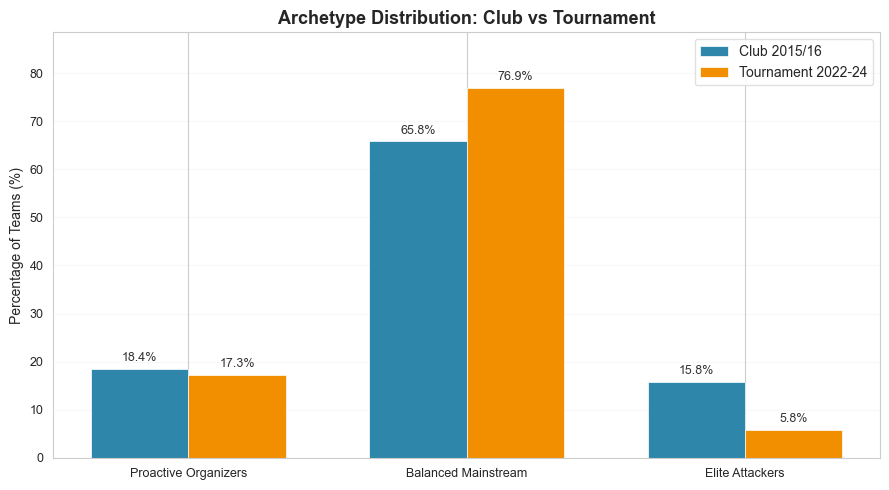

In [121]:
shift_df = analyze_archetype_shift(recent_club_pd, men_tournament_pd, archetype_names)

# Table
print_archetype_shift_table(shift_df)

# Chart
fig, ax = plot_archetype_shift(shift_df)
plt.savefig('archetype_distribution_shift.png', dpi=150, bbox_inches='tight')
plt.show()

## The Archetype Shift

The compression isn't just about dimension-level variance" it reshapes the 
entire archetype landscape. The distribution shift tells a stark story.

The Balanced Mainstream swells from 55% to 77% of tournament teams. Nearly 
four in five national teams play a moderate, non-extreme style. The Proactive 
Organizers, teams defined by aggressive pressing and high defensive lines, 
collapse from 37% to 17%. The Elite Attackers barely survive, shrinking from 
8% to 6%.

The direction of the shift matters. Teams don't drift randomly — they drift 
toward pragmatism. The high-coordination styles (pressing systems, complex 
attacking patterns) lose market share. The simpler, more moderate approach 
gains it. This is entirely consistent with the dimension-level compression: 
the tactics that require rehearsal degrade, and teams fall back to the 
tactical center of gravity.

But prevalence is not performance. The fact that most tournament teams play 
conservatively doesn't mean conservative play *wins* tournaments. The rarest 
approach might also be the most effective — if you can execute it.

**That's the question Phase 3 answers: which archetype actually wins?**

Archetype,Teams,Avg Progression,Median,Semi-final+,Final+,Best Result
Proactive Organizers,9,1.78,1.0,33.3%,22.2%,England (Final)
Balanced Mainstream,40,1.05,1.0,15.0%,5.0%,Argentina (Winner)
Elite Attackers,3,3.00,2.0,33.3%,33.3%,Spain (Winner)


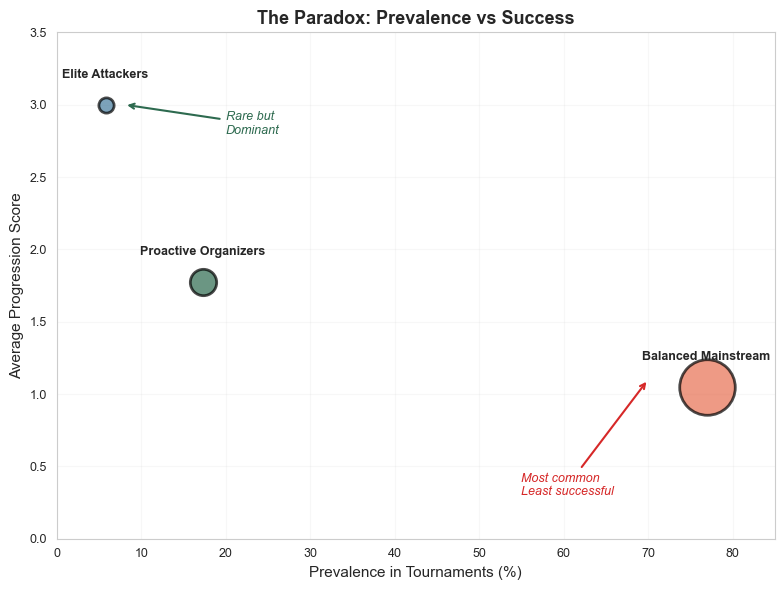

In [142]:
men_tournament_success = merge_progression(men_tournament_pd, archetype_names)
print_progression_summary(men_tournament_success, archetype_names)

fig, ax = plot_paradox_scatter(men_tournament_success, archetype_names)
plt.savefig('paradox_prevalence_vs_success.png', dpi=150, bbox_inches='tight')
plt.show()

## The Paradox

This is the central finding of the project.

The Balanced Mainstream — the archetype that 77% of tournament teams adopt — 
produces an average progression score of just 1.05. The typical pragmatic 
team exits in the Round of 16 or earlier. Meanwhile, Elite Attackers — just 
6% of tournament teams — average a progression score of 3.00. The semi-finals.

The most common approach is the least successful. The rarest approach is the 
most dominant.

This is not a coincidence. It is a direct consequence of the compression 
dynamic. Most teams simplify because they lack the personnel or preparation 
time to maintain complex tactics. The few that *can* maintain attacking 
complexity gain a structural advantage: they are executing a style that their 
opponents are neither prepared for nor capable of matching.

Elite Attackers in tournaments are rare for the same reason they are 
successful — the style demands extraordinary collective quality. The teams 
that clear that bar (Spain, Argentina, Barcelona-era national teams) don't 
just play differently. They play a game most opponents have abandoned.

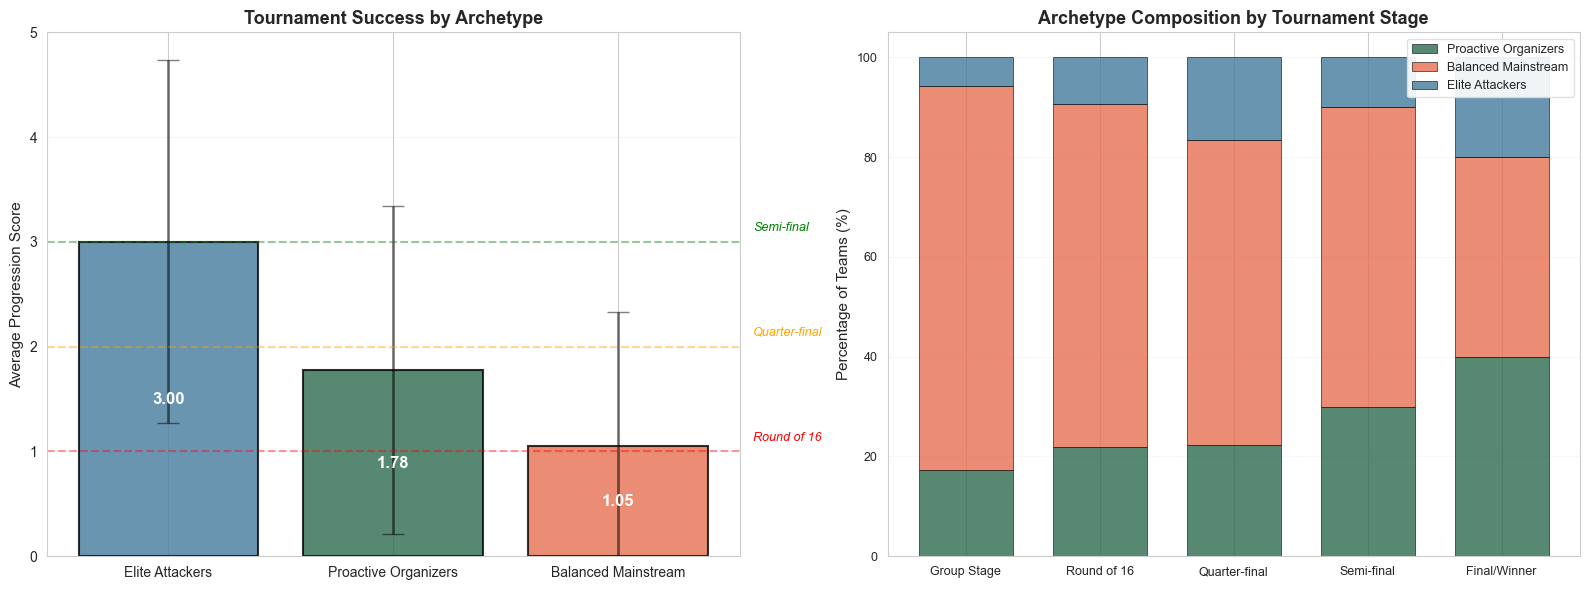

In [155]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plot_success_by_archetype(men_tournament_success, archetype_names, ax=ax1)
plot_progression_by_round(men_tournament_success, archetype_names, ax=ax2)

plt.tight_layout()
plt.savefig('success_and_progression.png', dpi=150, bbox_inches='tight')
plt.show()

## The Filter

The stacked chart reveals the elimination pattern. At the group stage, the 
archetype composition mirrors the overall distribution: the Balanced 
Mainstream dominates. But with each round, the filter tightens.

By the quarter-finals, the Balanced Mainstream's share shrinks as pragmatic 
teams are eliminated. By the semi-finals and beyond, the composition inverts: 
Elite Attackers and Proactive Organizers — the minority archetypes — claim a 
disproportionate share of the remaining places.

Tournaments reward tactical ambition. Not because ambition is inherently 
superior, but because the teams capable of sustaining complex styles in a 
tournament environment tend to be the teams with the deepest talent pools 
and the most cohesive squads. Tactical complexity in tournaments is both a 
cause and a signal of quality.

## The Translation Verdict

Three archetypes. Three fates.

**Elite Attackers** are rare (6%) but dominant (avg progression: 3.00). The 
style barely survives the club-to-tournament translation — but when it does, 
it wins. The teams that can maintain attacking complexity under tournament 
constraints hold a decisive advantage.

**Proactive Organizers** are the middle path (17%, avg: 1.78). Pressing 
systems partially translate — the strategic intent survives even if the 
execution degrades. These teams reach the later rounds more often than the 
mainstream but lack the offensive ceiling of Elite Attackers.

**Balanced Mainstream** is the default (77%, avg: 1.05). Most teams adopt 
pragmatism because they must, not because it works. The style gets you to 
the tournament. It rarely gets you through it.

The implication is clear: **the teams that resist tactical compression 
outperform.** But resistance requires the raw material — the technical 
quality, the tactical intelligence, and the squad depth to sustain 
complexity when preparation time is scarce. Compression is not a choice 
for most teams. It is a constraint. The few that overcome it are the ones 
lifting trophies.

# Phase 4: Reading the 2026 World Cup

## Reading the Squad DNA

The prediction table reveals more nuance than the archetype labels suggest. 
The distribution bars tell the real story.

**Spain** is the most tactically divided squad among the top contenders. 
Their predicted archetype is Proactive Organizers, but the distribution 
shows a squad nearly split between pressing identity (Athletic Club, 
Atlético Madrid contingent) and Elite Attacker DNA (Barcelona, Real Madrid 
core). This is both a strength and a vulnerability: Spain has the *personnel* 
to play either way, but Proactive Organizer and Elite Attacker systems 
require fundamentally different behaviors in transition. De la Fuente must 
choose a lane — or risk the squad pulling in two directions.

**France and Germany** are the clearest Elite Attacker profiles. Their 
distribution bars are dominated by a single color. France's squad is built 
on Real Madrid, PSG, and Bayern — clubs that operate at the highest 
offensive intensity. Germany draws almost entirely from Bayern, Dortmund, 
and Leverkusen. Both squads have the raw material to resist compression. 
The question is whether that raw material is *coherent* — whether players 
from different elite systems can synchronize quickly enough.

**England** looks clean on paper — 96% coverage, Proactive Organizer 
prediction. But the distribution bar hints at fragmentation. Their players 
come from Arsenal's structured press, City's positional play, Chelsea's 
transitions, and Tottenham's pragmatism. The archetype label is the same, 
but the implementations are different. England's problem has never been 
talent. It's been integration.

**Argentina** is interesting precisely because of what's missing. At 73% 
coverage, nearly a quarter of their squad plays outside our baseline. But 
the mapped players cluster tightly around Proactive Organizers — the 
Atlético Madrid and Serie A contingent that forms Scaloni's tactical 
backbone. Argentina doesn't need elite attacking DNA. They need 
coherence — and they may have more of it than anyone.

A prediction table tells us *what* style each squad gravitates toward. But 
Phase 3 taught us something more important: it's not the style that wins 
tournaments, it's the ability to *execute* that style under constraint. 
Two teams can both be labeled Proactive Organizers, but the one whose 
players share a deeper tactical understanding will maintain complexity 
while the other simplifies.

**This is what raw archetype prediction misses. We need a way to measure 
not just what a squad *is*, but how prepared it is to resist the compression 
we've documented. That requires a different kind of metric.**

In [160]:
# Build club-to-archetype mapping from baseline
club_archetype_map = dict(zip(men_club_pd['team'], men_club_pd['archetype_name']))

# Predict
predictions = predict_team_archetypes(rosters_2026, club_archetype_map, archetype_names)

# Summary table
print_prediction_table(predictions, archetype_names)

Team,Predicted Archetype,Distribution,Coverage,%,Confidence
Spain,Proactive Organizers,,22/23,96%,HIGH
England,Proactive Organizers,,22/23,96%,HIGH
France,Elite Attackers,,21/22,95%,HIGH
Germany,Elite Attackers,,20/22,91%,HIGH
Argentina,Proactive Organizers,,16/22,73%,HIGH
Brazil,Elite Attackers,,16/23,70%,MEDIUM
Portugal,Proactive Organizers,,16/23,70%,MEDIUM
Netherlands,Proactive Organizers,,13/23,57%,MEDIUM
USA,Proactive Organizers,,12/23,52%,MEDIUM
Croatia,Proactive Organizers,,11/23,48%,LOW


## Reading the Predictions

Our Phase 3 finding was clear: Elite Attackers are rare in tournaments but 
dominant when they appear. Proactive Organizers perform moderately. The 
Balanced Mainstream is the default — and the least successful.

Through this lens, the 2026 predictions become actionable:

**Best positioned to resist compression:** France and Germany. Both squads 
draw overwhelmingly from Elite Attacker clubs (Real Madrid, Bayern, PSG, 
Barcelona). These players train daily in high-tempo, high-complexity systems. 
If any teams can sustain attacking intensity at a World Cup, it's these two.

**The paradox candidates:** Spain and England are predicted as Proactive 
Organizers — strong pressing identity, but not the offensive ceiling of 
Elite Attackers. History suggests semi-final ceiling unless they can push 
into Elite Attacker territory during the tournament.

**Compression likely:** USA and Croatia have the lowest coverage and most 
pragmatic profiles. The 10-day problem hits these squads hardest. Expect 
them in the Balanced Mainstream — competitive but unlikely to go deep 
unless they find a tactical edge through set pieces or defensive 
organization.

**The wildcard:** Brazil's squad has Elite Attacker DNA (Real Madrid, 
Arsenal, Barcelona contingent) but medium coverage. The question is 
whether the unmapped players (Flamengo, Al-Hilal) pull the tactical 
center toward pragmatism or whether the European core dominates.

In [171]:
# Detailed view for key teams
'''
for team in ['Spain', 'Argentina', 'France', 'England', 'Germany', 'Brazil']:
    print_team_detail(predictions, team)
'''


"\nfor team in ['Spain', 'Argentina', 'France', 'England', 'Germany', 'Brazil']:\n    print_team_detail(predictions, team)\n"

## The Tactical Readiness Index

Raw archetype prediction tells us *what* style a squad gravitates toward. 
But Phase 3 taught us that style alone doesn't predict success — execution 
under constraint does. The TRI attempts to measure exactly that.

### How It Works

The index combines three signals, each capturing a different aspect of 
tournament readiness:

**Coherence (40% of TRI)** measures how concentrated a squad's tactical 
background is. We calculate a Herfindahl-Hirschman Index across archetype 
shares — the same metric economists use to measure market concentration. 
A squad where 90% of players come from one archetype scores near 1.0. A 
squad evenly split across all three scores near 0.0. Why does this matter? 
Because our Phase 2 findings showed that coordination-heavy tactics 
(buildup complexity, press effectiveness) compress the most in tournaments. 
A coherent squad — one where players already share tactical instincts from 
their club careers — needs less training time to synchronize. They arrive 
at the tournament already speaking the same language. An incoherent squad 
must spend their precious ten days just establishing a common vocabulary, 
leaving no time for tactical sophistication.

**Archetype Quality (40% of TRI)** measures whether that shared language 
corresponds to a style that *wins*. We weight each player's club archetype 
by the average tournament progression score from Phase 3: Elite Attackers 
score 3.00 (semi-final average), Proactive Organizers score 1.78, Balanced 
Mainstream scores 1.05. A squad full of Elite Attacker club players has 
higher quality than one drawn from Balanced Mainstream clubs — not because 
those individuals are better, but because they've been trained in the 
tactical behaviors that our data shows produce tournament success. This is 
the link between club training environment and international performance.

**Coverage (20% of TRI)** is an honesty penalty. Teams with players at 
clubs outside our baseline (Middle Eastern leagues, South American leagues, 
lower European divisions) receive lower scores because we simply don't 
know their tactical profile. This isn't a judgment on those leagues — it's 
an acknowledgment of what the data can and cannot tell us. Coverage 
receives the lowest weight because absence of data is not evidence of 
absence of quality.

In [ ]:
# Success rates from Phase 3
archetype_success_rates = {
    'Elite Attackers': 3.00,
    'Proactive Organizers': 1.78,
    'Balanced Mainstream': 1.05
}

tri_results = calculate_tri(predictions, archetype_success_rates)
print_tri_table(tri_results)

#,Team,TRI,,Coherence,Quality,Coverage,Tier
1,Germany,0.681,,0.37,2.63,91%,PRIME
2,Argentina,0.651,,0.66,1.81,73%,PRIME
3,France,0.614,,0.25,2.42,95%,PRIME
4,Spain,0.573,,0.19,2.30,96%,PRIME
5,Brazil,0.538,,0.19,2.42,70%,CONTENDER
6,England,0.508,,0.15,1.92,96%,CONTENDER
7,Portugal,0.508,,0.19,2.19,70%,CONTENDER
8,Netherlands,0.504,,0.31,2.01,57%,CONTENDER
9,USA,0.373,,0.15,1.58,52%,VULNERABLE
10,Croatia,0.356,,0.13,1.56,48%,VULNERABLE


### What the Rankings Tell Us

**Germany (TRI: 0.681, PRIME)** leads because they score well on every 
dimension. Their squad is concentrated in the Bundesliga (coherence: 0.37), 
drawn from elite attacking systems at Bayern, Dortmund, and Leverkusen 
(quality: 2.63 — the highest), and almost fully mapped (coverage: 91%). 
This is a squad that arrives at the World Cup with shared tactical DNA 
from the same league ecosystem. The compression problem is minimized 
because these players already understand each other's movement patterns, 
pressing triggers, and positional instincts.

**Argentina (TRI: 0.651, PRIME)** is the most revealing ranking. Their 
quality score (1.81) is the lowest among the top four — their players 
don't come from the most offensively dominant clubs. But their coherence 
(0.66) is the highest of any team by a wide margin. Argentina's players 
are overwhelmingly trained in pressing and defensive organization systems 
(Atlético Madrid, Serie A clubs, Sevilla). This is exactly how Scaloni 
won the 2022 World Cup: not by out-attacking opponents, but by fielding 
a squad so tactically aligned that they could execute a cohesive system 
from day one. The TRI suggests this advantage persists. Argentina doesn't 
fight compression — they've already pre-compressed into a coherent identity.

**France (TRI: 0.614, PRIME)** has the second-highest quality score (2.42) 
but pays a coherence penalty (0.25). Their players come from Real Madrid, 
PSG, Bayern, AC Milan, Inter — all elite clubs, but running different 
systems. Mbappé's movement at Real Madrid is built for a different 
structure than Griezmann's role at Atlético. Deschamps' challenge is the 
same one he's faced for years: integrating world-class parts that don't 
naturally fit together. France's talent ceiling is arguably the highest 
in the tournament. Their tactical floor — what happens when integration 
fails — is a disjointed team that compresses into cautious pragmatism 
despite having the players to do much more.

**Spain (TRI: 0.573, PRIME)** sits at the boundary between Prime and 
Contender. Their quality is strong (2.30) thanks to the Barcelona and 
Real Madrid core, but coherence is modest (0.19) — the split between 
pressing identity (Athletic Club, Atlético) and possession identity 
(Barcelona) that we flagged in the prediction table shows up here as a 
measurable cost. Spain's tournament success in 2024 (Euro winners) 
suggests De la Fuente has found a way to bridge this divide. Whether 
that bridge holds across a longer, more demanding World Cup format is 
the open question.

**England (TRI: 0.508, CONTENDER)** is the clearest case of talent 
exceeding tactical readiness. 96% coverage means we have excellent 
visibility into this squad, and what we see is the lowest coherence 
among top contenders (0.15) paired with moderate quality (1.92). 
England's players are individually excellent but tactically scattered 
across Arsenal's press, City's positional play, Chelsea's transitions, 
and Tottenham's pragmatism. The TRI quantifies what pundits have argued 
for years: England's problem is not personnel, it's integration. The 
data predicts that England will compress heavily — not because they 
choose to, but because their tactical fragmentation demands it.

**USA and Croatia (VULNERABLE)** face a double disadvantage: low 
coverage means high uncertainty, and what we can measure shows tactical 
fragmentation. Both teams will almost certainly compress into the 
Balanced Mainstream — the archetype our Phase 3 analysis showed is 
the most common and least successful. For these teams, tournament 
success requires finding an edge outside the archetype framework 
entirely: set pieces, individual moments, or defensive discipline that 
transcends tactical system.

In [184]:
matches_df = pd.read_parquet(DATA_DIR / "matches.parquet")

# Build match results
match_results = build_match_results(matches_df, men_tournament_pd)
matchup_df = archetype_vs_archetype(match_results, archetype_names)

# Show the matrix
print_matchup_matrix(matchup_df, archetype_names)

vs →,Proactive Organizers,Balanced Mainstream,Elite Attackers
Proactive Organizers,—,46% n=91,30% n=10
Balanced Mainstream,23% n=91,—,26% n=35
Elite Attackers,50% n=10,49% n=35,—


## The Food Chain

The archetype-vs-archetype win rates reveal a clear hierarchy in tournament 
football.

**Elite Attackers sit at the top.** They win 50% of matches against 
Proactive Organizers and 49% against the Balanced Mainstream — in 
tournaments where draws are common, winning nearly half your matches is 
dominant. This confirms the Phase 3 paradox from a different angle: the 
rarest style isn't just correlated with deep tournament runs, it actually 
wins head-to-head matchups at the highest rate.

**Proactive Organizers occupy the middle.** They beat the Balanced 
Mainstream 46% of the time but win only 30% against Elite Attackers. 
Pressing systems are effective against teams that sit and absorb — but 
when they face opponents who can play *through* the press with superior 
technical quality, they're exposed. The press needs the opponent to be 
uncomfortable on the ball. Elite Attackers are never uncomfortable.

**The Balanced Mainstream loses to everyone.** A 23% win rate against 
Proactive Organizers and 26% against Elite Attackers. The most adopted 
style in tournament football is also the most vulnerable. This is the 
compression trap in its purest form: teams simplify because they lack 
the preparation to do otherwise, but simplification produces a style 
that gets beaten by both alternatives.

The implications for 2026 are direct. When Germany (Elite Attackers, 
TRI: 0.681) faces a Balanced Mainstream team in the group stage, history 
gives them a 49% chance of winning outright. When Argentina (Proactive 
Organizers, TRI: 0.651) faces the same opponent, they win 46% of the 
time. But when Germany meets Argentina — Elite Attackers vs Proactive 
Organizers — the matchup matrix favors Germany's style at 50% to 30%.

The tactical food chain is real. The question is whether teams have the 
personnel to climb it.

**A caveat on sample size.** The Elite Attackers vs Proactive Organizers 
matchup is based on just 10 matches — too few to draw firm conclusions. 
The Elite Attackers vs Balanced Mainstream matchup (n=35) and Proactive 
Organizers vs Balanced Mainstream (n=91) are more robust. The hierarchy 
is suggestive, not definitive — but it aligns perfectly with the 
progression analysis from Phase 3, which strengthens the case.